# Acces to GDrive
These cells give access to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
pip install tsfresh

In [ ]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

#Importations

In [ ]:
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import *


import seaborn as sns
import matplotlib.pyplot as plt  

#Data extraction
These cells load the time series (from the json files) and labels (from data.csv).

In [ ]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m2l52fMnXSO_SIp_LRnX-NTjt50RJhwYdJ4cCKX1xa8/edit#gid=0')
data = wb.worksheet('data').get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [ ]:
start = 0
end = 385
sub_df = df[start:end]
sub_df.head()

,Name,Gender (W/M),"Fail, Zone or Top (0/1/2)",Competition,Climber,Country,Boulder Label
1,c1.mp4,M,0,WC (2021),Yannick Flohé,GER,1
2,c2.mp4,M,0,WC (2021),Jan Hojer,GER,2
3,c3.mp4,M,0,WC (2021),Yannick Flohé,GER,1
4,c4.mp4,M,1,WC (2021),Jan Hojer,GER,2
5,c5.mp4,M,1,WC (2021),Jan Hojer,GER,2


In [ ]:
path = '/content/drive/MyDrive/Boulder Project/'
names = sub_df["Name"].values

In [ ]:
df = []
y_climber = []
y_success = []

frames = 150
n = 0

for idx in range(len(names)):
  for ending in [".MOV", ".mp4"]:
    names[idx] = names[idx].replace(ending, "")
  
  path_landmarks = path + "json/" + names[idx] + "_landmarks.json"
  data = pd.read_json(path_landmarks)

  if len(data) >=frames:

    data['id'] = [n]*len(data)
    data['time'] = np.arange(0,len(data))
    df.append(data[:frames])

    y_climber.append(sub_df['Climber'][idx+1])
    y_success.append(sub_df['Fail, Zone or Top (0/1/2)'][idx+1])

    n += 1

df = pd.concat(df)
keys = df.keys()[:15]
for key in keys:
  x = key + "_x"
  y = key + "_y"
  df[x] = np.vstack(df[key].values)[:,0]
  df[y] = np.vstack(df[key].values)[:,1]

df = df.drop(columns = keys)

#Installation of tsfresh
**Warning: After the installation, the notebook has to be rerun again.**

#Features extraction and Features selection with tsfresh (using the original data)
**Remark: The features are stored and do not have to be extracted again for the next part**

In [ ]:
extracted_features = extract_features(df, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 5/5 [26:10<00:00, 314.14s/it]


In [ ]:
extracted_features.to_csv('/content/drive/MyDrive/Boulder Project/features/150Frames_features.csv')

In [ ]:
y_climber = pd.Series(data = y_climber, index = np.arange(0,329))
y_success = pd.Series(data = y_success, index = np.arange(0,329))

In [ ]:
impute(extracted_features)
features_filtered_climber = select_features(extracted_features, y_climber)
features_filtered_success = select_features(extracted_features, y_success)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['nose_x__fft_coefficient__attr_"real"__coeff_76'
 'nose_x__fft_coefficient__attr_"real"__coeff_77'
 'nose_x__fft_coefficient__attr_"real"__coeff_78' ...
 'right_heel_y__fft_coefficient__attr_"angle"__coeff_98'
 'right_heel_y__fft_coefficient__attr_"angle"__coeff_99'
 'right_heel_y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [ ]:
features_filtered_climber.to_csv('/content/drive/MyDrive/Boulder Project/features/150Frames_filtered_features_climber.csv')
features_filtered_success.to_csv('/content/drive/MyDrive/Boulder Project/features/150Frames_filtered_features_success.csv')

#Random Forest 10-fold CV (with the features from the original data)

In [ ]:
features_filtered_climber = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/150Frames_filtered_features_climber.csv')
features_filtered_success = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/150Frames_filtered_features_success.csv')

In [ ]:
y_climber = pd.Series(data = y_climber, index = np.arange(0,329))
y_success = pd.Series(data = y_success, index = np.arange(0,329))

**Climber prediction**

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

keys = features_filtered_climber.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_climber):
      X_train = np.array(features_filtered_climber[keys])[train]
      X_test = np.array(features_filtered_climber[keys])[test]
      Y_train = y_climber[train].values
      Y_test = y_climber[test].values
      clf_climber=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf_climber.fit(X_train,Y_train)
      y_pred_test=clf_climber.predict(X_test)
      y_pred_train=clf_climber.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(2, 1)
0.44034090909090906


In [ ]:
acc_test

array([[0.39176136, 0.40113636, 0.40113636, 0.40113636, 0.40113636],
       [0.40378788, 0.41912879, 0.41912879, 0.41912879, 0.41912879],
       [0.40388258, 0.44034091, 0.44034091, 0.44034091, 0.44034091],
       [0.40085227, 0.41922348, 0.41922348, 0.41922348, 0.41922348],
       [0.39763258, 0.43125   , 0.43125   , 0.43125   , 0.43125   ],
       [0.39469697, 0.434375  , 0.434375  , 0.434375  , 0.434375  ],
       [0.41297348, 0.434375  , 0.434375  , 0.434375  , 0.434375  ],
       [0.41590909, 0.4375    , 0.4375    , 0.4375    , 0.4375    ],
       [0.40691288, 0.43143939, 0.43143939, 0.43143939, 0.43143939],
       [0.40700758, 0.4375947 , 0.4375947 , 0.4375947 , 0.4375947 ]])

In [ ]:
acc_train

array([[0.99966216, 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

**Achievement prediction**

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

keys = features_filtered_success.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_success):
      X_train = np.array(features_filtered_success[keys])[train]
      X_test = np.array(features_filtered_success[keys])[test]
      Y_train = y_success[train].values
      Y_test = y_success[test].values
      clf_climber=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf_climber.fit(X_train,Y_train)
      y_pred_test=clf_climber.predict(X_test)
      y_pred_train=clf_climber.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(9, 1)
0.5834280303030303


In [ ]:
print(acc_train)
print(acc_test)

[[0.99864865 1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.99966216 1.         1.         1.         1.        ]
 [0.99966216 1.         1.         1.         1.        ]
 [0.99966216 1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
[[0.54119318 0.54393939 0.54393939 0.54393939 0.54393939]
 [0.5592803  0.5561553  0.5561553  0.5561553  0.5561553 ]
 [0.56534091 0.553125   0.553125   0.553125   0.553125  ]
 [0.56837121 0.56524621 0.56524621 0.56524621 0.56524621]
 [0.57130682 0.57433712 0.57433712 0.57433712 0.57433712]
 [0.57130682 0.57130682 0.57130682 0.57130682 0.57130682]
 [0.57130682 0.57443182 0.57443182 0.57443182 0.57443182]
 [0.58039773 

#Data Augmentation Functions
Functions from: https://github.com/uchidalab/time_series_augmentation

In [ ]:
import numpy as np
import math
import sys

RETURN_VALUE = 0
RETURN_PATH = 1
RETURN_ALL = -1

# Core DTW
def _traceback(DTW, slope_constraint):
    i, j = np.array(DTW.shape) - 1
    p, q = [i-1], [j-1]
    
    if slope_constraint == "asymmetric":
        while (i > 1):
            tb = np.argmin((DTW[i-1, j], DTW[i-1, j-1], DTW[i-1, j-2]))

            if (tb == 0):
                i = i - 1
            elif (tb == 1):
                i = i - 1
                j = j - 1
            elif (tb == 2):
                i = i - 1
                j = j - 2

            p.insert(0, i-1)
            q.insert(0, j-1)
    elif slope_constraint == "symmetric":
        while (i > 1 or j > 1):
            tb = np.argmin((DTW[i-1, j-1], DTW[i-1, j], DTW[i, j-1]))

            if (tb == 0):
                i = i - 1
                j = j - 1
            elif (tb == 1):
                i = i - 1
            elif (tb == 2):
                j = j - 1

            p.insert(0, i-1)
            q.insert(0, j-1)
    else:
        sys.exit("Unknown slope constraint %s"%slope_constraint)
        
    return (np.array(p), np.array(q))

def dtw(prototype, sample, return_flag = RETURN_VALUE, slope_constraint="asymmetric", window=None):
    """ Computes the DTW of two sequences.
    :param prototype: np array [0..b]
    :param sample: np array [0..t]
    :param extended: bool
    """
    p = prototype.shape[0]
    assert p != 0, "Prototype empty!"
    s = sample.shape[0]
    assert s != 0, "Sample empty!"
    
    if window is None:
        window = s
    
    cost = np.full((p, s), np.inf)
    for i in range(p):
        start = max(0, i-window)
        end = min(s, i+window)+1
        cost[i,start:end]=np.linalg.norm(sample[start:end] - prototype[i], axis=1)

    DTW = _cummulative_matrix(cost, slope_constraint, window)
        
    if return_flag == RETURN_ALL:
        return DTW[-1,-1], cost, DTW[1:,1:], _traceback(DTW, slope_constraint)
    elif return_flag == RETURN_PATH:
        return _traceback(DTW, slope_constraint)
    else:
        return DTW[-1,-1]

def _cummulative_matrix(cost, slope_constraint, window):
    p = cost.shape[0]
    s = cost.shape[1]
    
    # Note: DTW is one larger than cost and the original patterns
    DTW = np.full((p+1, s+1), np.inf)

    DTW[0, 0] = 0.0

    if slope_constraint == "asymmetric":
        for i in range(1, p+1):
            if i <= window+1:
                DTW[i,1] = cost[i-1,0] + min(DTW[i-1,0], DTW[i-1,1])
            for j in range(max(2, i-window), min(s, i+window)+1):
                DTW[i,j] = cost[i-1,j-1] + min(DTW[i-1,j-2], DTW[i-1,j-1], DTW[i-1,j])
    elif slope_constraint == "symmetric":
        for i in range(1, p+1):
            for j in range(max(1, i-window), min(s, i+window)+1):
                DTW[i,j] = cost[i-1,j-1] + min(DTW[i-1,j-1], DTW[i,j-1], DTW[i-1,j])
    else:
        sys.exit("Unknown slope constraint %s"%slope_constraint)
        
    return DTW

def shape_dtw(prototype, sample, return_flag = RETURN_VALUE, slope_constraint="asymmetric", window=None, descr_ratio=0.05):
    """ Computes the shapeDTW of two sequences.
    :param prototype: np array [0..b]
    :param sample: np array [0..t]
    :param extended: bool
    """
    # shapeDTW
    # https://www.sciencedirect.com/science/article/pii/S0031320317303710
    
    p = prototype.shape[0]
    assert p != 0, "Prototype empty!"
    s = sample.shape[0]
    assert s != 0, "Sample empty!"
    
    if window is None:
        window = s
        
    p_feature_len = np.clip(np.round(p * descr_ratio), 5, 100).astype(int)
    s_feature_len = np.clip(np.round(s * descr_ratio), 5, 100).astype(int)
    
    # padding
    p_pad_front = (np.ceil(p_feature_len / 2.)).astype(int)
    p_pad_back = (np.floor(p_feature_len / 2.)).astype(int)
    s_pad_front = (np.ceil(s_feature_len / 2.)).astype(int)
    s_pad_back = (np.floor(s_feature_len / 2.)).astype(int)
    
    prototype_pad = np.pad(prototype, ((p_pad_front, p_pad_back), (0, 0)), mode="edge") 
    sample_pad = np.pad(sample, ((s_pad_front, s_pad_back), (0, 0)), mode="edge") 
    p_p = prototype_pad.shape[0]
    s_p = sample_pad.shape[0]
        
    cost = np.full((p, s), np.inf)
    for i in range(p):
        for j in range(max(0, i-window), min(s, i+window)):
            cost[i, j] = np.linalg.norm(sample_pad[j:j+s_feature_len] - prototype_pad[i:i+p_feature_len])
            
    DTW = _cummulative_matrix(cost, slope_constraint=slope_constraint, window=window)
    
    if return_flag == RETURN_ALL:
        return DTW[-1,-1], cost, DTW[1:,1:], _traceback(DTW, slope_constraint)
    elif return_flag == RETURN_PATH:
        return _traceback(DTW, slope_constraint)
    else:
        return DTW[-1,-1]

In [ ]:
import numpy as np
from tqdm import tqdm

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def discriminative_guided_warp(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True, verbose=0):
    # use verbose = -1 to turn off warnings
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    # dtw_type is for shapeDTW or DTW. "normal" or "shape"
    
    
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    positive_batch = np.ceil(batch_size / 2).astype(int)
    negative_batch = np.floor(batch_size / 2).astype(int)
        
    ret = np.zeros_like(x)
    warp_amount = np.zeros(x.shape[0])
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        
        # remove ones of different classes
        positive = np.where(l[choices] == l[i])[0]
        negative = np.where(l[choices] != l[i])[0]
        
        if positive.size > 0 and negative.size > 0:
            pos_k = min(positive.size, positive_batch)
            neg_k = min(negative.size, negative_batch)
            positive_prototypes = x[np.random.choice(positive, pos_k, replace=False)]
            negative_prototypes = x[np.random.choice(negative, neg_k, replace=False)]
                        
            # vector embedding and nearest prototype in one
            pos_aves = np.zeros((pos_k))
            neg_aves = np.zeros((pos_k))
            if dtw_type == "shape":
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*shape_dtw(pos_prot, pos_samp, RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*shape_dtw(pos_prot, neg_samp, RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = shape_dtw(positive_prototypes[selected_id], pat, RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                for p, pos_prot in enumerate(positive_prototypes):
                    for ps, pos_samp in enumerate(positive_prototypes):
                        if p != ps:
                            pos_aves[p] += (1./(pos_k-1.))*dtw(pos_prot, pos_samp, RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                    for ns, neg_samp in enumerate(negative_prototypes):
                        neg_aves[p] += (1./neg_k)*dtw(pos_prot, neg_samp, RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                selected_id = np.argmax(neg_aves - pos_aves)
                path = dtw(positive_prototypes[selected_id], pat, RETURN_PATH, slope_constraint=slope_constraint, window=window)
                   
            # Time warp
            warped = pat[path[1]]
            warp_path_interp = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), path[1])
            warp_amount[i] = np.sum(np.abs(orig_steps-warp_path_interp))
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d"%l[i])
            ret[i,:] = pat
            warp_amount[i] = 0.
    if use_variable_slice:
        max_warp = np.max(warp_amount)
        if max_warp == 0:
            # unchanged
            ret = window_slice(ret, reduce_ratio=0.9)
        else:
            for i, pat in enumerate(ret):
                # Variable Sllicing
                ret[i] = window_slice(pat[np.newaxis,:,:], reduce_ratio=0.9+0.1*warp_amount[i]/max_warp)[0]
    return ret

#Data Augmentation
These cells augment the data using DGW. Thereby two augmented data sets are formed, one based on the lable series `y_climber` and one on `y_success`.

In [ ]:
keys = df.keys()
batch = len(y_climber)
time_step = frames
channel = len(keys[2:])
X = np.empty([batch, time_step, channel])

for n in range(batch):
  X[n,:,:] = df.loc[df['id'] == n][keys[2:]]

In [ ]:
Y_climber = pd.get_dummies(y_climber).values
Y_success = pd.get_dummies(y_success).values

In [ ]:
xx_climber = discriminative_guided_warp(X, Y_climber, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True)
xx_success = discriminative_guided_warp(X, Y_success, batch_size=6, slope_constraint="symmetric", use_window=True, dtw_type="normal", use_variable_slice=True)

 33%|███▎      | 107/329 [00:15<00:25,  8.78it/s]

There is only one pattern of class 4


 38%|███▊      | 126/329 [00:18<00:20,  9.83it/s]

There is only one pattern of class 6


 50%|████▉     | 164/329 [00:23<00:18,  8.81it/s]

There is only one pattern of class 9


 68%|██████▊   | 225/329 [00:32<00:11,  8.93it/s]

There is only one pattern of class 18


 74%|███████▍  | 244/329 [00:34<00:09,  8.77it/s]

There is only one pattern of class 22


100%|██████████| 329/329 [00:48<00:00,  6.79it/s]


In [ ]:
xx_df_climber = []
l = len(y_climber)
for i in range(batch):
  x_df = pd.DataFrame(columns = keys)
  x_df['id'] = [i+l]*150
  x_df['time'] = np.arange(150)
  x_df[keys[2:]] = xx_climber[i,:,:]
  xx_df_climber.append(x_df)

xx_df_climber = pd.concat(xx_df_climber)
  
df_climber = pd.concat([df, xx_df_climber])

In [ ]:
xx_df_success = []
l = len(y_success)
for i in range(batch):
  x_df = pd.DataFrame(columns = keys)
  x_df['id'] = [i+l]*150
  x_df['time'] = np.arange(150)
  x_df[keys[2:]] = xx_success[i,:,:]
  xx_df_success.append(x_df)

xx_df_success = pd.concat(xx_df_success)
  
df_success = pd.concat([df, xx_df_success])

#Features extraction and Features selection with tsfresh (using the augmented data)
**Remark: The features are stored and do not have to be extracted again for the next parts**

In [ ]:
extracted_features_climber = extract_features(df_climber, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 5/5 [47:48<00:00, 573.61s/it]


In [ ]:
extracted_features_climber.to_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_features_climber.csv')

In [ ]:
extracted_features_success = extract_features(df_success, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 5/5 [49:43<00:00, 596.78s/it]


In [ ]:
extracted_features_success.to_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_features_success.csv')

In [ ]:
features_climber = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_features_climber.csv')
features_success = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_features_success.csv')

In [ ]:
y_c = pd.Series(data = y_climber, index = np.arange(0,329))
y_s = pd.Series(data = y_success, index = np.arange(0,329))
y_c = pd.Series(data = y_c.append(y_c).values, index = np.arange(0,658))
y_s = pd.Series(data = y_s.append(y_s).values, index = np.arange(0,658))

In [ ]:
impute(features_climber)
features_filtered_climber = select_features(features_climber, y_c)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['nose_x__fft_coefficient__attr_"real"__coeff_76'
 'nose_x__fft_coefficient__attr_"real"__coeff_77'
 'nose_x__fft_coefficient__attr_"real"__coeff_78' ...
 'right_heel_y__fft_coefficient__attr_"angle"__coeff_98'
 'right_heel_y__fft_coefficient__attr_"angle"__coeff_99'
 'right_heel_y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [ ]:
impute(features_success)
features_filtered_success = select_features(features_success, y_s)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['nose_x__fft_coefficient__attr_"real"__coeff_76'
 'nose_x__fft_coefficient__attr_"real"__coeff_77'
 'nose_x__fft_coefficient__attr_"real"__coeff_78' ...
 'right_heel_y__fft_coefficient__attr_"angle"__coeff_98'
 'right_heel_y__fft_coefficient__attr_"angle"__coeff_99'
 'right_heel_y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [ ]:
features_filtered_climber.to_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_filtered_features_climber.csv')
features_filtered_success.to_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_filtered_features_success.csv')

# Random Forest 10-fold CV (with the features from the augmented data)

In [ ]:
features_filtered_climber = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_filtered_features_climber.csv')
features_filtered_success = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_filtered_features_success.csv')

In [ ]:
y_c = pd.Series(data = y_climber, index = np.arange(0,329))
y_s = pd.Series(data = y_success, index = np.arange(0,329))
y_c = pd.Series(data = y_c.append(y_c).values, index = np.arange(0,658))
y_s = pd.Series(data = y_s.append(y_s).values, index = np.arange(0,658))

**Climber prediction**

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

keys = features_filtered_climber.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_c):
      X_train = np.array(features_filtered_climber[keys])[train]
      X_test = np.array(features_filtered_climber[keys])[test]
      Y_train = y_c[train].values
      Y_test = y_c[test].values
      clf=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(9, 2)
0.8812820512820514


In [ ]:
acc_train

array([[0.99966216, 1.        , 1.        , 1.        , 1.        ],
       [0.99983108, 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [ ]:
acc_test

array([[0.76265734, 0.8432634 , 0.84629371, 0.84629371, 0.84629371],
       [0.78554779, 0.85848485, 0.86153846, 0.86153846, 0.86153846],
       [0.79009324, 0.86      , 0.8630303 , 0.8630303 , 0.8630303 ],
       [0.79165501, 0.86459207, 0.86762238, 0.86762238, 0.86762238],
       [0.80386946, 0.87829837, 0.87675991, 0.87675991, 0.87675991],
       [0.80841492, 0.87675991, 0.87827506, 0.87827506, 0.87827506],
       [0.80689977, 0.87524476, 0.87675991, 0.87675991, 0.87675991],
       [0.81449883, 0.87522145, 0.87825175, 0.87825175, 0.87825175],
       [0.82205128, 0.87522145, 0.87370629, 0.87370629, 0.87370629],
       [0.81748252, 0.8797669 , 0.88128205, 0.88128205, 0.88128205]])

**Achievement prediction**

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10,25,50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

keys = features_filtered_success.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_s):
      X_train = np.array(features_filtered_success[keys])[train]
      X_test = np.array(features_filtered_success[keys])[test]
      Y_train = y_s[train].values
      Y_test = y_s[test].values
      clf=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(8, 1)
0.8037762237762237


In [ ]:
acc_train

array([[0.99814332, 1.        , 1.        , 1.        , 1.        ],
       [0.99898677, 1.        , 1.        , 1.        , 1.        ],
       [0.99949324, 1.        , 1.        , 1.        , 1.        ],
       [0.99949324, 1.        , 1.        , 1.        , 1.        ],
       [0.99983108, 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [ ]:
acc_test

array([[0.74158508, 0.77501166, 0.77501166, 0.77501166, 0.77501166],
       [0.7430303 , 0.77794872, 0.77643357, 0.77643357, 0.77643357],
       [0.74305361, 0.78400932, 0.78400932, 0.78400932, 0.78400932],
       [0.75214452, 0.78554779, 0.78403263, 0.78403263, 0.78403263],
       [0.75822844, 0.79006993, 0.78855478, 0.78855478, 0.78855478],
       [0.75519814, 0.79004662, 0.79156177, 0.79156177, 0.79156177],
       [0.76284382, 0.79610723, 0.79610723, 0.79610723, 0.79610723],
       [0.75979021, 0.8006993 , 0.8006993 , 0.8006993 , 0.8006993 ],
       [0.76130536, 0.80377622, 0.80377622, 0.80377622, 0.80377622],
       [0.76587413, 0.79762238, 0.79762238, 0.79762238, 0.79762238]])

# Confusion matrix (with Random Forest using the optimized Parameters and the features from the augmented data)

In [ ]:
features_filtered_climber = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_filtered_features_climber.csv')
features_filtered_success = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/Aug_150Frames_filtered_features_success.csv')

In [ ]:
y_c = pd.Series(data = y_climber, index = np.arange(0,329))
y_s = pd.Series(data = y_success, index = np.arange(0,329))
y_c = pd.Series(data = y_c.append(y_c).values, index = np.arange(0,658))
y_s = pd.Series(data = y_s.append(y_s).values, index = np.arange(0,658))

In [ ]:
n_c = 500
d_c = 50
n_s = 450
d_s = 25

**Climber prediction**

In [ ]:
k = 10
unique_c = y_c.unique()
keys = features_filtered_climber.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
M = np.zeros((23,23))
counts = pd.Series(data = np.zeros(23), index = unique_c)
tmp_train = []
tmp_test = []
tmp_ajusted_train = []
tmp_ajusted_test = []

for train, test in kf.split(y_c):
      X_train = np.array(features_filtered_climber[keys])[train]
      X_test = np.array(features_filtered_climber[keys])[test]
      Y_train = y_c[train].values
      Y_test = y_c[test].values
      clf=RandomForestClassifier(n_estimators=n_c, max_depth = d_c, random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      M = M + metrics.confusion_matrix(Y_test, y_pred_test, labels = unique_c)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))
      tmp_ajusted_train.append(metrics.balanced_accuracy_score(Y_train, y_pred_train))
      tmp_ajusted_test.append(metrics.balanced_accuracy_score(Y_test, y_pred_test))

M = M/np.sum(M)
print('train accuracy = ' + str(np.mean(tmp_train)))
print('test accuracy = ' +  str(np.mean(tmp_test)))
print('train ajusted accuracy = ' + str(np.mean(tmp_ajusted_train)))
print('test ajusted accuracy = ' +  str(np.mean(tmp_ajusted_test)))
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train accuracy = 1.0
test accuracy = 0.8812820512820514
train ajusted accuracy = 1.0
test ajusted accuracy = 0.8641902665009283


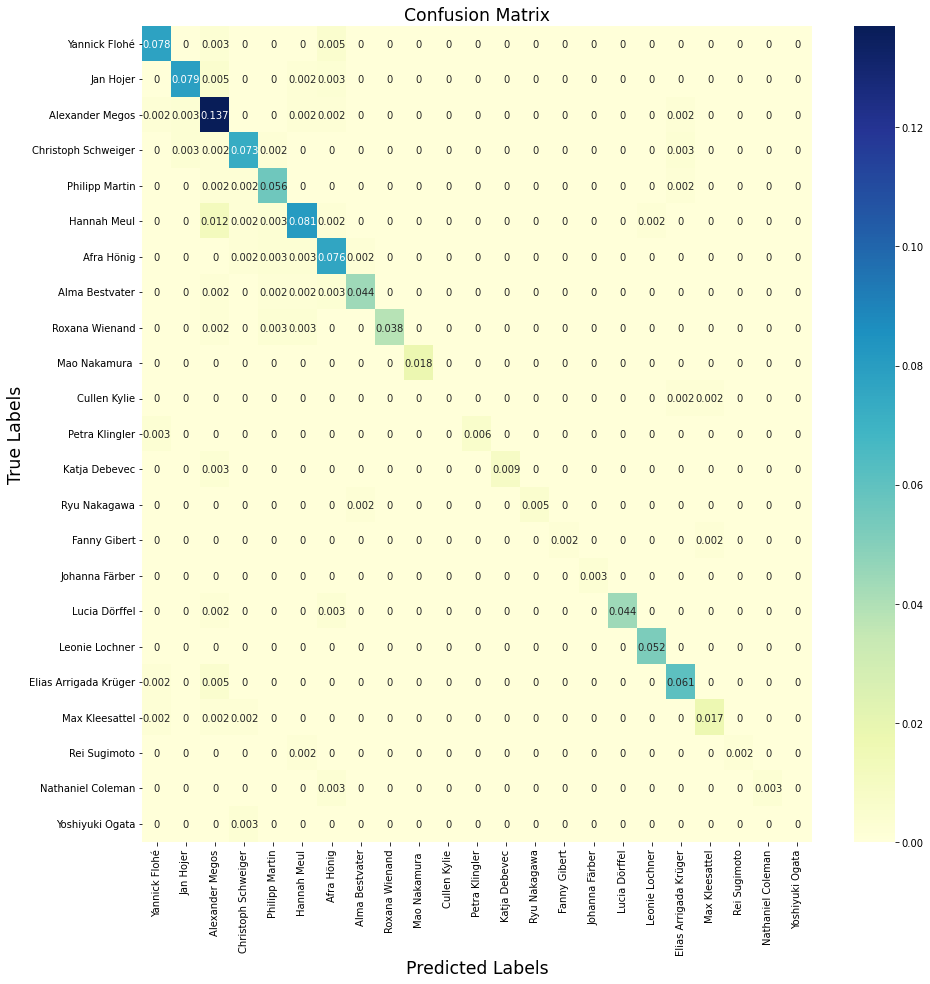

In [ ]:
images_dir = '/content/drive/MyDrive/Boulder Project/figures/'

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(np.round(M,3), annot=True, fmt='g', xticklabels = unique_c, yticklabels = unique_c, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted Labels', fontsize = 'xx-large')
ax.set_ylabel('True Labels', fontsize = 'xx-large')
ax.set_title('Confusion Matrix', fontsize = 'xx-large')
fig.savefig(f"{images_dir}Confusion_Matrix_climber_AugData_150F.png")
fig.show()

**Achievement prediction**

In [ ]:
k = 10
unique_s = y_s.unique()
keys = features_filtered_success.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
M = np.zeros((3,3))
counts = pd.Series(data = np.zeros(3), index = unique_s)
tmp_train = []
tmp_test = []
tmp_ajusted_train = []
tmp_ajusted_test = []

for train, test in kf.split(y_s):
      X_train = np.array(features_filtered_success[keys])[train]
      X_test = np.array(features_filtered_success[keys])[test]
      Y_train = y_s[train].values
      Y_test = y_s[test].values
      clf=RandomForestClassifier(n_estimators=n_s, max_depth = d_s, random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      M = M + metrics.confusion_matrix(Y_test, y_pred_test, labels = unique_s)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))
      tmp_ajusted_train.append(metrics.balanced_accuracy_score(Y_train, y_pred_train))
      tmp_ajusted_test.append(metrics.balanced_accuracy_score(Y_test, y_pred_test))

M = M/np.sum(M)
print('train accuracy = ' + str(np.mean(tmp_train)))
print('test accuracy = ' +  str(np.mean(tmp_test)))
print('train ajusted accuracy = ' + str(np.mean(tmp_ajusted_train)))
print('test ajusted accuracy = ' +  str(np.mean(tmp_ajusted_test)))
      

train accuracy = 1.0
test accuracy = 0.8037762237762237
train ajusted accuracy = 1.0
test ajusted accuracy = 0.7330075261924531


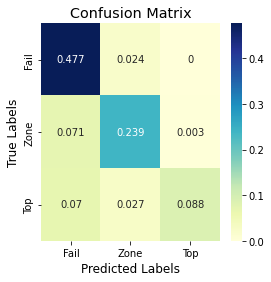

In [ ]:
images_dir = '/content/drive/MyDrive/Boulder Project/figures/'
labels = ['Fail', 'Zone', 'Top']

fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
sns.heatmap(np.round(M,3), annot=True, fmt='g', xticklabels = labels, yticklabels = labels, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted Labels', fontsize = 'large')
ax.set_ylabel('True Labels', fontsize = 'large')
ax.set_title('Confusion Matrix', fontsize = 'x-large')
fig.savefig(f"{images_dir}Confusion_Matrix_success_AugData_150F.png")
fig.show()